In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np
import matplotlib.lines as lines

In [2]:
seed = 2704
validation_size = 0.2
input_dir = "data/images"
target_dir = "data/mask"

In [3]:
df = pd.read_csv('data/dataset.csv')  
df.head()

,image_name,part,section,min_height,max_height,diff_height,piece_position,class,image_id
0,P01_001_0,1,0,181,200,19,Down,2,1
1,P01_001_1,1,1,198,208,10,Down,1,1
2,P01_001_2,1,2,204,214,10,Down,1,1
3,P01_001_3,1,3,200,212,12,Down,1,1
4,P01_002_0,1,0,232,238,6,Down,1,2


In [4]:
df['part'] = df['image_name'].apply(lambda x: x.split('_')[0])
df['class'] = np.where(df['class']==1, 0, np.where(df['class']==2, 0, 1))

In [5]:
train, test = train_test_split(df, test_size=validation_size, random_state= seed, shuffle=True, stratify = df['class'])
df['set'] = 'Train'
df.loc[test.index, 'set']='Test'
train.shape, test.shape

((856, 9), (215, 9))

In [6]:
df.head()

,image_name,part,section,min_height,max_height,diff_height,piece_position,class,image_id,set
0,P01_001_0,P01,0,181,200,19,Down,0,1,Train
1,P01_001_1,P01,1,198,208,10,Down,0,1,Train
2,P01_001_2,P01,2,204,214,10,Down,0,1,Test
3,P01_001_3,P01,3,200,212,12,Down,0,1,Train
4,P01_002_0,P01,0,232,238,6,Down,0,2,Test


In [7]:
df['location'] = 0 
df['location'] = np.where(
    np.logical_and(df['class']==0,df['set']=='Train'), 
    df.index%80, 
    np.where(np.logical_and(df['class']==0,df['set']=='Test'),80+(df.index%20), df['location']))
df['location'] = np.where(
    np.logical_and(df['class']==1,df['set']=='Train'), 
    150+(df.index%80), 
    np.where(np.logical_and(df['class']==1,df['set']=='Test'),230+(df.index%20),df['location']))

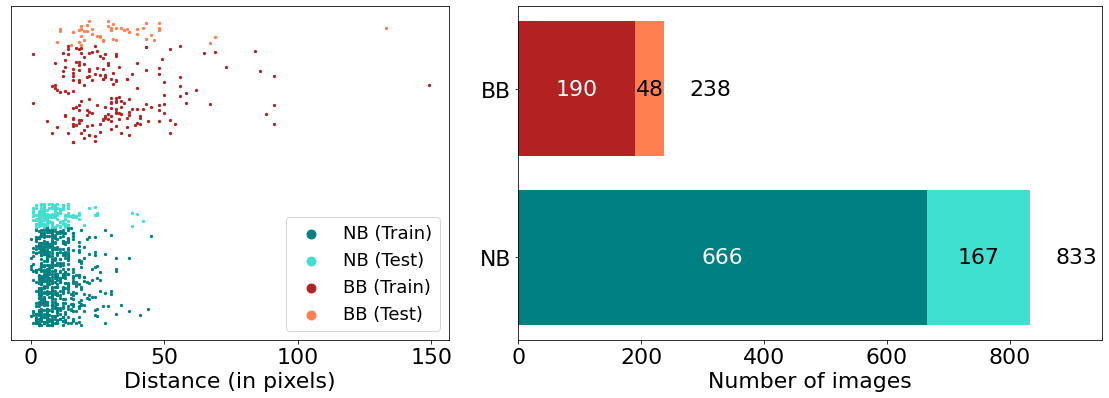

In [8]:
def generate_graph(df):

    fig, ax = plt.subplots(1,2, figsize=(16, 6), gridspec_kw={'width_ratios': [3, 4]})
    df = df.sort_values(by=['class'], ignore_index=True)

    classes= ['NB', 'BB']
    x = []

    colors = ['teal', 'firebrick']
    colors_stacked = ['turquoise', 'coral']

    for c, t, color, color_s in zip([0,1], classes, colors, colors_stacked):
        df_filter_train = df[(df['class']==c) & (df['set']=='Train')]
        df_filter_val = df[(df['class']==c) & (df['set']=='Test')]
        ax[0].scatter(df_filter_train['diff_height'].values, df_filter_train['location'].values, s= 5, label=t+' (Train)', c=color)
        ax[0].scatter(df_filter_val['diff_height'].values, df_filter_val['location'].values, s= 5, label=t+' (Test)', c=color_s)
        count_train = [df_filter_train.shape[0]]
        count_val = [df_filter_val.shape[0]]
        p1 = ax[1].barh([t], count_train, label=t, color = color)
        p2 = ax[1].barh([t], count_val, left=count_train, label=[t], color = color_s)
        x.append(count_train)
        
        
        ax[1].bar_label(p1, label_type='center', color='white')
        ax[1].bar_label(p2, label_type='center')
        ax[1].bar_label(p2, padding = 25)
        
    ax[0].legend(prop={'size': 18}, markerscale=4)

    ax[0].axes.get_yaxis().set_visible(False)
    ax[0].set_xlabel('Distance (in pixels)')
    ax[1].set_xlabel('Number of images')
    """
    for container in ax[1].containers:
        if (container.datavalues) not in x:
            ax[1].bar_label(container)
    """
    ax[1].set_xlim([0, 950])

plt.rcParams.update({'font.size': 22})
generate_graph(df)
plt.tight_layout()
plt.savefig('results/img_dataset_info.png', dpi=600)
plt.show()

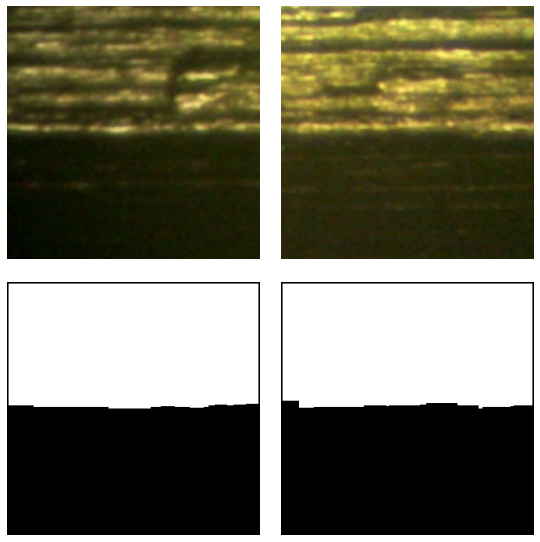

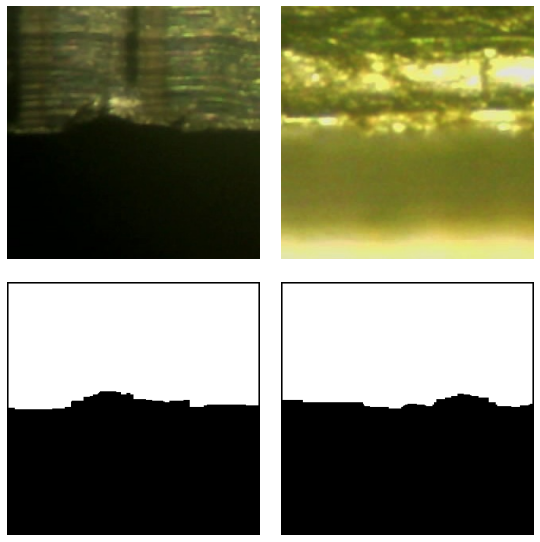

In [9]:
df['image_path'] = input_dir+'/'+df['image_name']+'.jpg'
df['mask_path'] = target_dir+'/'+df['image_name']+'.png'

names = ['NB', 'BB']

for class_id, class_name in zip([0,1], names):
    df_class = df[df['class']==class_id]
    fig, ax = plt.subplots(2,2, figsize=(8, 8))
    for index, image in zip(range(0,2),[28,2]):
    
        img = cv2.cvtColor(cv2.imread(df_class.iloc[image].image_path), cv2.COLOR_BGR2RGB)            
        ax[0][index].imshow(img)
        ax[0][index].axis('off')

        mask = cv2.imread(df_class.iloc[image].mask_path, cv2.IMREAD_GRAYSCALE) //255
        mask = np.pad(mask, ((2, 2), (2, 2)), constant_values=0)
        ax[1][index].imshow(mask, cmap='gray')
        ax[1][index].axis('off')
    #ax[0][class_id-1].set_title(names[class_id-1])
    plt.tight_layout()
    plt.savefig('results/img_dataset_'+class_name+'.png', dpi=600)
    plt.show()